In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [4]:
import io
google_stock_data = pd.read_csv(io.BytesIO(uploaded['GOOG.csv']))


NameError: name 'uploaded' is not defined

In [5]:
google_stock_data.info()

NameError: name 'google_stock_data' is not defined

In [6]:
google_stock_data = google_stock_data[['date','open','close']] # Extracting required columns
google_stock_data['date'] = pd.to_datetime(google_stock_data['date'].apply(lambda x: x.split()[0])) # Selecting only date
google_stock_data.set_index('date',drop=True,inplace=True) # Setting date column as index
google_stock_data.head()

NameError: name 'google_stock_data' is not defined

NameError: name 'google_stock_data' is not defined

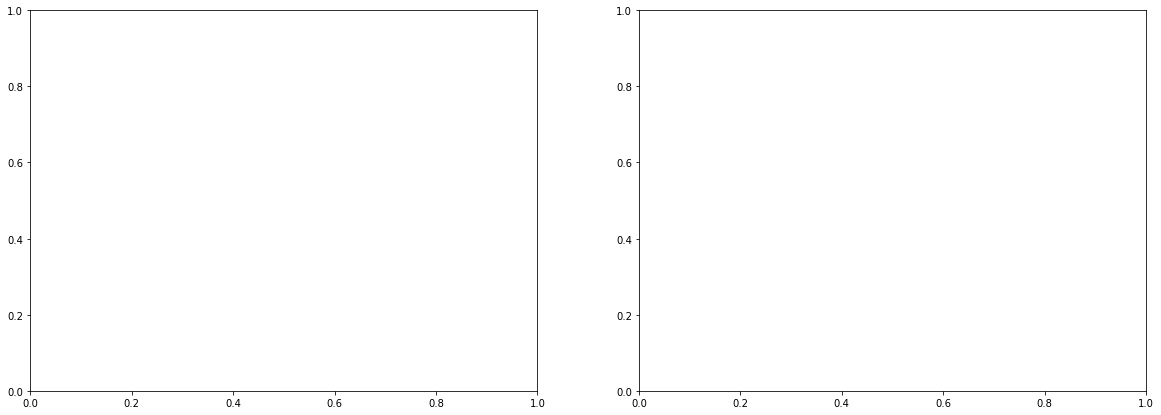

In [7]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(google_stock_data['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(google_stock_data['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

# Data Pre-Processing

In [9]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
google_stock_data[google_stock_data.columns] = MMS.fit_transform(google_stock_data)

In [10]:
google_stock_data.shape

(1258, 2)

In [11]:
training_size = round(len(google_stock_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

1006

In [12]:
train_data = google_stock_data[:training_size]
test_data  = google_stock_data[training_size:]

train_data.shape, test_data.shape

((1006, 2), (252, 2))

In [13]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))


In [14]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [15]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((956, 50, 2), (956, 2), (202, 50, 2), (202, 2))

# Creating LSTM model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1))
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
30/30 [==============================] - 8s 101ms/step - loss: 0.0082 - mean_absolute_error: 0.0618 - val_loss: 0.0102 - val_mean_absolute_error: 0.0834
Epoch 2/80
30/30 [==============================] - 3s 101ms/step - loss: 8.2392e-04 - mean_absolute_error: 0.0223 - val_loss: 0.0092 - val_mean_absolute_error: 0.0826
Epoch 3/80
30/30 [==============================] - 4s 146ms/step - loss: 6.0014e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0037 - val_mean_absolute_error: 0.0489
Epoch 4/80
30/30 [==============================] - 3s 101ms/step - loss: 5.2656e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0030 - val_mean_absolute_error: 0.0435
Epoch 5/80
30/30 [==============================] - 2s 82ms/step - loss: 4.8933e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0027 - val_mean_absolute_error: 0.0409
Epoch 6/80
30/30 [==============================] - 1s 48ms/step - loss: 4.7039e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0029 - val_mean_absolute_error: 0.042

In [19]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

7/7 [==============================] - 1s 21ms/step


array([[0.47798193, 0.48992082],
       [0.48492643, 0.49712205],
       [0.4899919 , 0.5024545 ],
       [0.5011555 , 0.5135952 ],
       [0.5109186 , 0.5237236 ]], dtype=float32)

In [20]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[1557.1403, 1576.2499],
       [1570.0148, 1589.5962],
       [1579.4058, 1599.4791],
       [1600.1022, 1620.1266],
       [1618.2023, 1638.898 ]], dtype=float32)

# Visualizing predicted and actual data

In [21]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([google_stock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=google_stock_data.iloc[-202:].index)], axis=1)

In [22]:
gs_slic_data[['open','close']] = MMS.inverse_transform(gs_slic_data[['open','close']]) # Inverse scaling

In [23]:
gs_slic_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,1593.98,1588.20,1557.140259,1576.249878
2020-08-25,1582.07,1608.22,1570.014771,1589.596191
2020-08-26,1608.00,1652.38,1579.405762,1599.479126
2020-08-27,1653.68,1634.33,1600.102173,1620.126587
2020-08-28,1633.49,1644.41,1618.202271,1638.897949


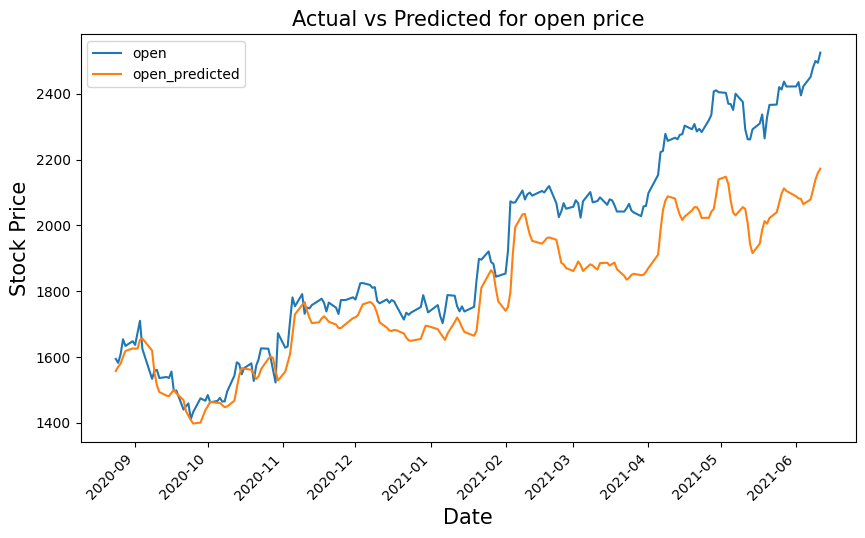

In [24]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

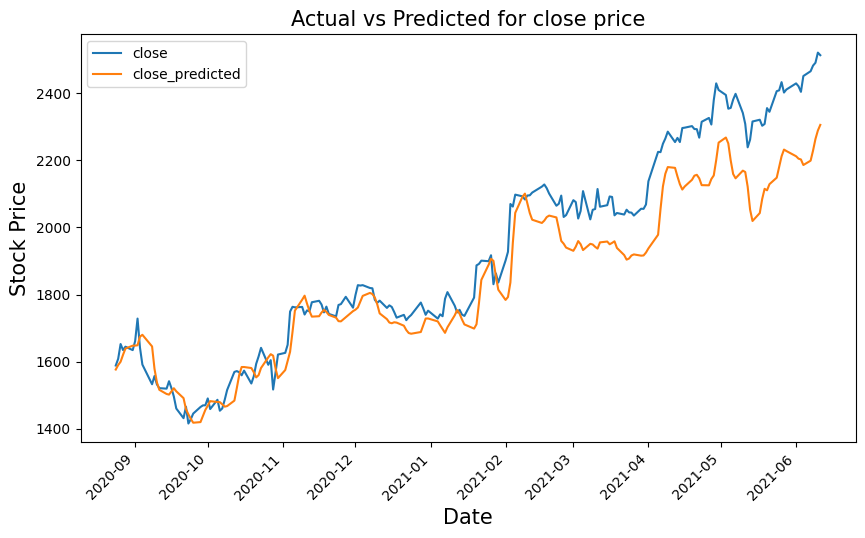

In [25]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

# Predicting upcoming 10 days

In [26]:
# Creating a dataframe and adding 10 days to existing index

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))


In [27]:
gs_slic_data['2021-06-09	':'2021-06-16']

,open,close,open_predicted,close_predicted
2021-06-09,2499.50,2491.40,2138.929443,2263.988770
2021-06-10,2494.01,2521.60,2159.440918,2289.226807
2021-06-11,2524.92,2513.93,2172.053955,2306.037354
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


In [28]:
upcoming_prediction = pd.DataFrame(columns=['open','close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [29]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)


1/1 [==============================] - 0s 38ms/step


In [30]:
upcoming_prediction[['open','close']] = MMS.inverse_transform(upcoming_prediction[['open','close']])

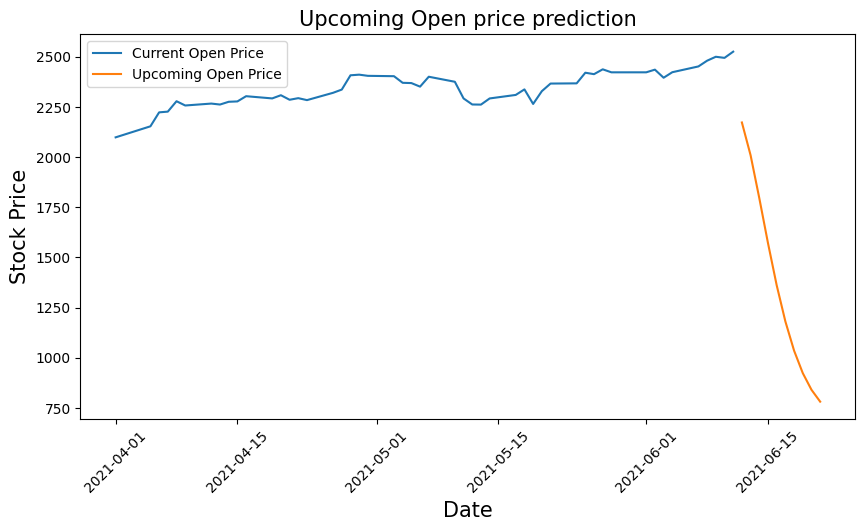

In [31]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

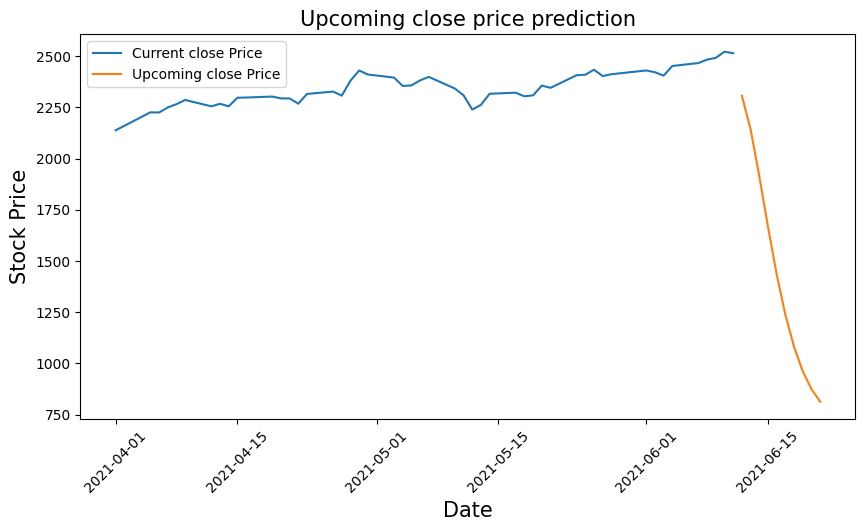

In [32]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()